In [17]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from RandomForestForTimeSeriesRegressor import RandomForestForTimeSeriesRegressor, BLOCK_TYPES

In [18]:
dataset = pd.read_csv('../../datasets/sp_500_stocks/sp500_index.csv')

In [19]:
dataset = dataset.dropna()
dataset = dataset.sort_values("Date")
dataset

,Date,S&P500
0,2014-12-01,2053.44
1,2014-12-02,2066.55
2,2014-12-03,2074.33
3,2014-12-04,2071.92
4,2014-12-05,2075.37
...,...,...
2512,2024-11-22,5969.34
2513,2024-11-25,5987.37
2514,2024-11-26,6021.63
2515,2024-11-27,5998.74


In [20]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['DateOrdinal'] = dataset['Date'].map(dt.datetime.toordinal)
dataset['average_price'] = dataset["S&P500"]
dataset = dataset.drop(columns=["S&P500"])
dataset['DayOfWeek'] = dataset['Date'].dt.dayofweek
dataset['Month'] = dataset['Date'].dt.month
dataset['Year'] = dataset['Date'].dt.year
dataset['DayOfYear'] = dataset['Date'].dt.dayofyear
dataset['WeekOfYear'] = dataset['Date'].dt.isocalendar().week

dataset['is_start_of_month'] = (dataset['Date'].dt.day == 1).astype(int)
dataset['is_end_of_month'] = (dataset['Date'] == dataset['Date'] + pd.offsets.MonthEnd(0)).astype(int)
dataset['quarter'] = dataset['Date'].dt.quarter
def get_season(month):
    if month in [12, 1, 2]:
        return 0#'winter'
    elif month in [3, 4, 5]:
        return 1#'spring'
    elif month in [6, 7, 8]:
        return 2#'summer'
    else:
        return 3#'autumn'
dataset['season'] = dataset['Month'].apply(get_season)
dataset['SerieNumber'] = (dataset['Date'] - dataset['Date'].min()).dt.days + 1


days_ago = 30

#dataset["price_30_days_ago"] = dataset["average_price"].shift(days_ago)
#dataset["price_180_days_ago"] = dataset["average_price"].shift(180)
#dataset["price_365_days_ago"] = dataset["average_price"].shift(365)

calculatedFields = ["DateOrdinal", "DayOfWeek", "Month", "Year", "DayOfYear", "WeekOfYear", "is_start_of_month", "is_end_of_month", "quarter",
                    "season", "SerieNumber"] #, "price_30_days_ago", "price_180_days_ago", "price_365_days_ago"]
fieldsPrice = ["average_price"]


dataset = dataset.dropna().reset_index(drop=True)

dataset

,Date,DateOrdinal,average_price,DayOfWeek,Month,Year,DayOfYear,WeekOfYear,is_start_of_month,is_end_of_month,quarter,season,SerieNumber
0,2014-12-01,735568,2053.44,0,12,2014,335,49,1,0,4,0,1
1,2014-12-02,735569,2066.55,1,12,2014,336,49,0,0,4,0,2
2,2014-12-03,735570,2074.33,2,12,2014,337,49,0,0,4,0,3
3,2014-12-04,735571,2071.92,3,12,2014,338,49,0,0,4,0,4
4,2014-12-05,735572,2075.37,4,12,2014,339,49,0,0,4,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,2024-11-22,739212,5969.34,4,11,2024,327,47,0,0,4,3,3645
2513,2024-11-25,739215,5987.37,0,11,2024,330,48,0,0,4,3,3648
2514,2024-11-26,739216,6021.63,1,11,2024,331,48,0,0,4,3,3649
2515,2024-11-27,739217,5998.74,2,11,2024,332,48,0,0,4,3,3650


In [21]:
trainPercent = 80
trainSamples = (len(dataset.index) // 100) * trainPercent
testSamples = len(dataset.index) - trainSamples

In [22]:
def getRandomBlock(dataset0, blockDayRange):
    max_date = pd.to_datetime(dataset0['Date'].max())
    min_valid_date = max_date - pd.DateOffset(years=1)  # Fecha máxima menos un año
    
    valid_dates = dataset0[dataset0['Date'] <= min_valid_date]['Date']
    if valid_dates.empty:
        raise ValueError("No hay fechas válidas en el rango permitido.")
    
    random_start_date = np.random.choice(valid_dates)
    end_date = random_start_date + pd.DateOffset(days=blockDayRange)
    
    filtered_df = dataset0[(dataset0['Date'] >= random_start_date) & (dataset0['Date'] <= end_date)]
    return filtered_df

In [23]:
def getRandomTrainTestData(dataset0, daysRange, trainDays):
    blockDf = getRandomBlock(dataset0, daysRange)
    min_date = pd.to_datetime(dataset0['Date'].min())
    train_max_day = min_date + pd.DateOffset(days=trainDays)
    trainSamples = dataset0[dataset0['Date'] < train_max_day].shape[0]
    testSamples = len(dataset0.index) - trainSamples

    aux = dataset0.copy()
    aux = aux.drop("Date", axis=1)
    X = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y = aux.copy()

    X_train = X.iloc[:trainSamples]
    Y_train = Y.iloc[:trainSamples]
    X_test = X.iloc[-testSamples:]
    Y_test = Y.iloc[-testSamples:]

    return X_train, Y_train, X_test, Y_test

In [24]:
aux = dataset.copy()
aux = aux.drop("Date", axis=1)
X = aux[calculatedFields].copy()
aux = aux.drop(calculatedFields, axis=1)

Y = aux.copy()

X_train = X.iloc[:trainSamples]
Y_train = Y.iloc[:trainSamples]
X_test = X.iloc[-testSamples:]
Y_test = Y.iloc[-testSamples:]

In [25]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

# basicRFPrecision = []
# for i in range(50):
#     X_train0, Y_train0, X_test0, Y_test0 = getRandomTrainTestData(dataset, 730, 365)
#     basicRF = RandomForestRegressor(n_jobs=100, n_estimators=100, max_depth=10)
#     basicRF.fit(X_train0, Y_train0)
#     y_pred = basicRF.predict(X_test0)
#     rmse0 = sqrt(mean_squared_error(Y_test0, y_pred))
#     print(f"RMSE:")
#     print(rmse0)
#     basicRFPrecision.append(rmse0)
basicRFPrecision = []
for i in range(50):
    basicRF = RandomForestRegressor(n_jobs=100, n_estimators=100, max_depth=10)
    basicRF.fit(X_train, Y_train)
    y_pred = basicRF.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    print(f"RMSE:")
    print(rmse0)
    basicRFPrecision.append(rmse0)

In [27]:
# daysOfBlocks = 730
# daysOfTraining = 365
# X_train0, Y_train0, X_test0, Y_test0 = getRandomTrainTestData(dataset, daysOfBlocks, daysOfTraining)
#totalSamplesAprox = X_train.shape[0]
#blockSizes = [totalSamplesAprox / 100, totalSamplesAprox / 50, totalSamplesAprox / 25, totalSamplesAprox / 10, totalSamplesAprox / 5]
#for i in range(len(blockSizes)):
#    blockSizes[i] = int(blockSizes[i])
blockSizes = [15, 30, 60, 150, 300]


In [28]:
def testRftsAndGetRmseByAlgorithm(dataset0, daysOfBlocks0, daysOfTraining0, block_size0, algorithm0):
    X_train0, Y_train0, X_test0, Y_test0 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    rfts = RandomForestForTimeSeriesRegressor(n_jobs=100, n_estimators=100, block_size=block_size0, max_depth=10, block_type=BLOCK_TYPES[algorithm0])
    rfts.fit(X_train0, Y_train0)
    y_pred = rfts.predict(X_test0)
    rmse0 = sqrt(mean_squared_error(Y_test0, y_pred))
    return rmse0

In [29]:
# precisionNonOverlapping = dict()
# for block_size in blockSizes:
#     precisionNonOverlapping[block_size] = []
#     for k in range(10):
#         rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 0)
#         print(f"RMSE: ({block_size}, {k})")
#         print(rmse0)
#         precisionNonOverlapping[block_size].append(rmse0)
precisionNonOverlapping = dict()
for block_size in blockSizes:
    precisionNonOverlapping[block_size] = []
    for k in range(50):
        rfts = RandomForestForTimeSeriesRegressor(n_jobs=100, n_estimators=100, block_size=block_size, max_depth=10)
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
        print(f"RMSE: ({block_size}, {k})")
        print(rmse0)
        precisionNonOverlapping[block_size].append(rmse0)

RMSE: (15, 0)
1103.091908046451
RMSE: (15, 1)
1106.329265536375
RMSE: (15, 2)
1129.6282358838369
RMSE: (15, 3)
1114.0717138716384
RMSE: (15, 4)
1095.3609756194817
RMSE: (15, 5)
1099.7157686871437
RMSE: (15, 6)
1108.95890541561
RMSE: (15, 7)
1105.164560116126
RMSE: (15, 8)
1123.9429667535462
RMSE: (15, 9)
1101.456616077997
RMSE: (15, 10)
1100.7264339784026
RMSE: (15, 11)
1098.1024278518735
RMSE: (15, 12)
1102.0482132706554
RMSE: (15, 13)
1103.292582988872
RMSE: (15, 14)
1131.165261093167
RMSE: (15, 15)
1108.8701351550426
RMSE: (15, 16)
1094.429757422641
RMSE: (15, 17)
1098.1421939120157
RMSE: (15, 18)
1086.9733029451595
RMSE: (15, 19)
1112.3549457584077
RMSE: (15, 20)
1088.413111718512
RMSE: (15, 21)
1112.9613480751364
RMSE: (15, 22)
1113.4262163517228
RMSE: (15, 23)
1109.0095550233216
RMSE: (15, 24)
1108.7359436419288
RMSE: (15, 25)
1088.4225636201706
RMSE: (15, 26)
1114.8425695520468
RMSE: (15, 27)
1119.8934875235764
RMSE: (15, 28)
1102.6348723171336
RMSE: (15, 29)
1109.1957701303404


In [30]:
def getGraphData(presitionDataArray):
    all_arr = [basicRFPrecision]
    ticksIdx = [0]
    ticksNames = ["RF"]
    idx = 0
    for blockSize in blockSizes:
        
        data0 = []
        for r in presitionDataArray[blockSize]:
            data0.append(r)

        all_arr.append(data0)
        idx += 1
        ticksIdx.append(idx)
        ticksNames.append(str(blockSize))

    return all_arr, ticksIdx, ticksNames

Text(0, 0.5, 'RMSE')

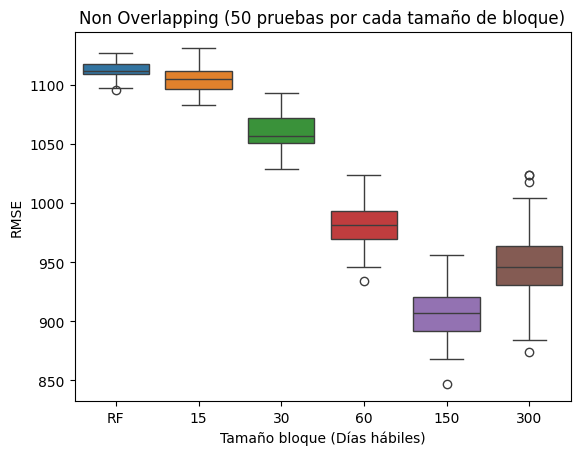

In [31]:
from matplotlib import pyplot as plt

all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping)

sns.boxplot(data=all_arr)
plt.xticks(ticksIdx, ticksNames)
plt.title("Non Overlapping (50 pruebas por cada tamaño de bloque)")
plt.xlabel("Tamaño bloque (Días hábiles)")
plt.ylabel("RMSE")

In [32]:
# precisionMovingBlock = dict()
# for block_size in blockSizes:
#     precisionMovingBlock[block_size] = []
#     for k in range(10):
#         rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 1)
#         print(f"RMSE: ({block_size}, {k})")
#         print(rmse0)
#         precisionMovingBlock[block_size].append(rmse0)
precisionMovingBlock = dict()
for block_size in blockSizes:
    precisionMovingBlock[block_size] = []
    for k in range(50):
        rfts = RandomForestForTimeSeriesRegressor(n_jobs=100, n_estimators=500, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[1])
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
        print(f"RMSE: ({block_size}, {k})")
        print(rmse0)
        precisionMovingBlock[block_size].append(rmse0)

RMSE: (15, 0)
1089.5781886094749
RMSE: (15, 1)
1092.178996797177
RMSE: (15, 2)
1077.8278556722562
RMSE: (15, 3)
1082.9302874532166
RMSE: (15, 4)
1089.399421662002
RMSE: (15, 5)
1081.182336809476
RMSE: (15, 6)
1086.438956842791
RMSE: (15, 7)
1086.220098251292
RMSE: (15, 8)
1083.0522483635918
RMSE: (15, 9)
1078.141059220997
RMSE: (15, 10)
1088.0624102483264
RMSE: (15, 11)
1078.998174693286
RMSE: (15, 12)
1087.9974618644583
RMSE: (15, 13)
1081.585759776962
RMSE: (15, 14)
1082.9107279097468
RMSE: (15, 15)
1082.0180830623221
RMSE: (15, 16)
1088.5345021610267
RMSE: (15, 17)
1081.5763714377606
RMSE: (15, 18)
1077.1981122081884
RMSE: (15, 19)
1076.989245630349
RMSE: (15, 20)
1076.413835812898
RMSE: (15, 21)
1080.4178886234245
RMSE: (15, 22)
1082.617695401148
RMSE: (15, 23)
1074.5661071933084
RMSE: (15, 24)
1079.413853179067
RMSE: (15, 25)
1084.270872187845
RMSE: (15, 26)
1086.7218611241915
RMSE: (15, 27)
1087.529641955348
RMSE: (15, 28)
1074.5158947702819
RMSE: (15, 29)
1080.692743225488
RMSE:

Text(0, 0.5, 'RMSE')

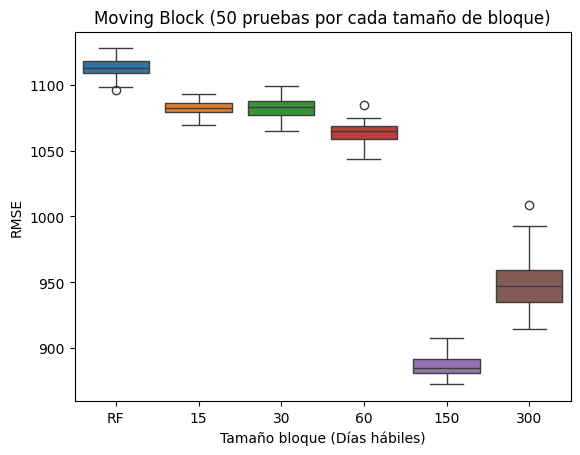

In [33]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionMovingBlock)

sns.boxplot(data=all_arr)
plt.xticks(ticksIdx, ticksNames)
plt.title("Moving Block (50 pruebas por cada tamaño de bloque)")
plt.xlabel("Tamaño bloque (Días hábiles)")
plt.ylabel("RMSE")

In [34]:
# precisionCircularBlock = dict()
# for block_size in blockSizes:
#     precisionCircularBlock[block_size] = []
#     for k in range(10):
#         rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 2)
#         print(f"RMSE: ({block_size}, {k})")
#         print(rmse0)
#         precisionCircularBlock[block_size].append(rmse0)
precisionCircularBlock = dict()
for block_size in blockSizes:
    precisionCircularBlock[block_size] = []
    for k in range(50):
        rfts = RandomForestForTimeSeriesRegressor(n_jobs=100, n_estimators=100, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[2])
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
        print(f"RMSE: ({block_size}, {k})")
        print(rmse0)
        precisionCircularBlock[block_size].append(rmse0)

RMSE: (15, 0)
1095.5221324169777
RMSE: (15, 1)
1083.0383124088385
RMSE: (15, 2)
1097.3803682533285
RMSE: (15, 3)
1077.3525454869869
RMSE: (15, 4)
1081.4238479089065
RMSE: (15, 5)
1091.890073696226
RMSE: (15, 6)
1083.5986304015987
RMSE: (15, 7)
1069.3614467186028
RMSE: (15, 8)
1087.0867928084558
RMSE: (15, 9)
1068.0352743891458
RMSE: (15, 10)
1076.1469767363217
RMSE: (15, 11)
1100.4310424439686
RMSE: (15, 12)
1083.8071101973467
RMSE: (15, 13)
1087.294962553441
RMSE: (15, 14)
1078.8750353118605
RMSE: (15, 15)
1104.6249046638488
RMSE: (15, 16)
1082.7511332125625
RMSE: (15, 17)
1052.6566792064125
RMSE: (15, 18)
1090.9770981440092
RMSE: (15, 19)
1082.6710190674635
RMSE: (15, 20)
1082.8007120366315
RMSE: (15, 21)
1090.961396630676
RMSE: (15, 22)
1099.964556378157
RMSE: (15, 23)
1087.5832744880872
RMSE: (15, 24)
1077.8589351517921
RMSE: (15, 25)
1093.2343941792644
RMSE: (15, 26)
1090.8313111202426
RMSE: (15, 27)
1089.1648290934045
RMSE: (15, 28)
1084.4478182919836
RMSE: (15, 29)
1074.63544293

Text(0, 0.5, 'RMSE')

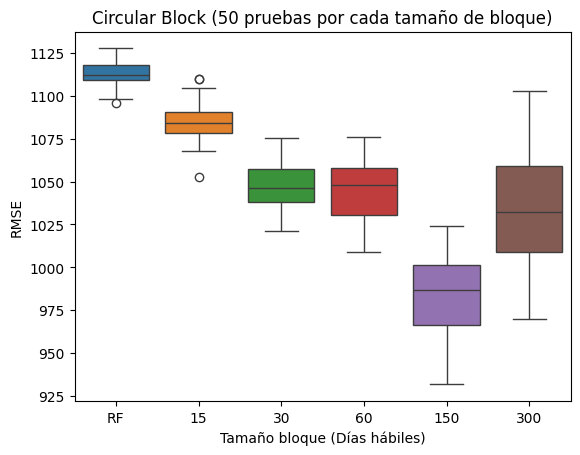

In [35]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionCircularBlock)

sns.boxplot(data=all_arr)
plt.xticks(ticksIdx, ticksNames)
plt.title("Circular Block (50 pruebas por cada tamaño de bloque)")
plt.xlabel("Tamaño bloque (Días hábiles)")
plt.ylabel("RMSE")

Text(29.472222222222214, 0.5, 'RMSE')

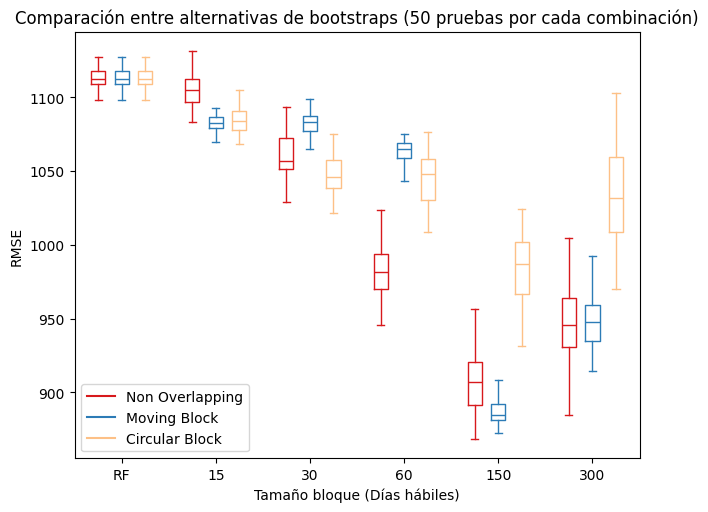

In [36]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping)
all_arr1, ticksIdx, ticksNames = getGraphData(precisionMovingBlock)
all_arr2, ticksIdx, ticksNames = getGraphData(precisionCircularBlock)

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bp0 = plt.boxplot(all_arr, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.boxplot(all_arr1, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.boxplot(all_arr2, positions=np.array(range(len(all_arr1)))*2.0+0.5, sym='', widths=0.3)
set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bp1, '#2C7BB6')
set_box_color(bp2, '#fdc086')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Non Overlapping')
plt.plot([], c='#2C7BB6', label='Moving Block')
plt.plot([], c='#fdc086', label='Circular Block')
plt.legend()

plt.xticks(range(0, len(ticksNames) * 2, 2), ticksNames)
# plt.xlim(-2, len(ticks)*2)
#plt.ylim(34, 55)
plt.tight_layout()
plt.title("Comparación entre alternativas de bootstraps (50 pruebas por cada combinación)")
plt.xlabel("Tamaño bloque (Días hábiles)")
plt.ylabel("RMSE")